In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from collections import Counter

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

In [5]:
from scipy import stats
from scipy.stats import norm, gamma, linregress, skew
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, confusion_matrix, silhouette_score, silhouette_samples

In [6]:
def dump_pickle(file, filename):
    outfile = open(filename, 'wb')
    pickle.dump(file, outfile)
    outfile.close()

def load_pickle(filename):
    infile = open(filename, 'rb')
    file = pickle.load(infile)
    infile.close()
    return file

In [7]:
sns.set()

## Data Prep

### Read Synergy + CTG Data

In [8]:
s_df = pd.read_csv('nba_offense_plus_ctg.csv')
s_df.shape

(2860, 61)

Filter in players with 200+ playtype possessions

In [9]:
s_df = s_df[s_df['Overall_Poss'] >= 200]
s_df.shape

(1714, 61)

### Read BBR Data

In [10]:
bbr_df = pd.read_csv('bbr_nba_stats.csv')
bbr_df.shape

(2323, 39)

### Merge Synergy Data & BBR Data

In [11]:
s_df['Player_Alt'] = s_df['Player'].apply(lambda x: x.replace(' ', '').lower())\
                                   .apply(lambda x: x.replace("'", ''))\
                                   .apply(lambda x: x.replace('.', ''))

In [12]:
bbr_df['player_alt_alt'] = bbr_df['player_alt'].apply(lambda x: x.replace(' ', ''))\
                                               .apply(lambda x: x.replace("'", ''))\
                                               .apply(lambda x: x.replace('.', ''))\
                                               .apply(lambda x: x.lower())

In [13]:

synergy_name_dict = {'kevinknoxii': 'kevinknox',
                     'danilogalinari': 'danilogallinari',
                     'louiswilliams': 'louwilliams',
                     'eneskanter': 'enesfreedom',
                     'terryrozieriii': 'terryrozier',
                     'cameronreddish': 'camreddish',
                     'jahilokafor': 'jahlilokafor',
                     'danuelhouse': 'danuelhousejr',
                     'alfarouqaminu': 'al-farouqaminu',
                     'nenehilario': 'nene',
                     'frankmason': 'frankmasoniii',
                     'larrynance': 'larrynancejr',
                     'wesleyiwundu': 'wesiwundu',
                     'robertwilliamsiii': 'robertwilliams',
                     'harrygilesiii': 'harrygiles',
                     'jamesennis': 'jamesennisiii',
                     'mohamedbamba': 'mobamba',
                     'xaviertillman': 'xaviertillmansr',
                     'patrickbeverly': 'patrickbeverley',
                     'malcomdelaney': 'malcolmdelaney',
                     'marcusmorrissr': 'marcusmorris',
                     'nicolasclaxton': 'nicclaxton',
                     'juanhernangomez': 'juanchohernangomez',
                     'guillermohernangomez': 'willyhernangomez',
                     'timothéluwawu-cabarrot': 'timotheluwawu-cabarrot',
                     'nahshonhyland': 'boneshyland'}

In [14]:
s_df['Player_Alt'] = s_df['Player_Alt']\
                     .apply(lambda x: synergy_name_dict.get(x, x))

In [15]:
df = s_df.merge(bbr_df, how='left', 
                left_on=['Player_Alt', 'Team', 'Season'],
                right_on=['player_alt_alt', 'team', 'Season'])
df = df[~df['player_alt_alt'].isna()].reset_index().drop('index', axis=1)
df.shape

(1714, 101)

In [16]:
# check 
df[['Player_Alt', 'Team', 'Season']].drop_duplicates().shape

(1714, 3)

## Clustering

### Functions

In [17]:
def plot_pca_explained_var(x):
    ev_list = []
    c_list = list(range(2, 12))
    for c in c_list:
        pca = PCA(n_components=c)
        ev_list.append(np.sum(pca.fit(x).explained_variance_ratio_))
    
    # Plot
    plt.plot(c_list, ev_list)
    plt.hlines(0.95, 2, 11, color='red', linestyle='--')
    plt.xlabel('Number of Components (c)')
    plt.ylabel('Explained Variance Ratio')
    plt.title('PCA Results')

In [18]:
def plot_silhouette_score(x):
    avg_ss_list = []
    k_list = list(range(2, 16))
    for k in k_list:
        sc = SpectralClustering(n_clusters=k, 
                                affinity='nearest_neighbors', 
                                random_state=42)
        cluster_labels = sc.fit(x).labels_
        avg_silhouette_score = silhouette_score(x, cluster_labels)
        avg_ss_list.append(avg_silhouette_score)

    # Plot
    # Plot the elbow
    plt.plot(k_list, avg_ss_list, 'bx-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Average Silhouette Score')
    plt.title('The Silhouette Score Method Showing the Optimal k')

### Define Weight Columns

In [20]:
playtypes = ['Isolation', 'P&R Ball Handler', 'Post-Up', 
             'P&R Roll Man', 'Spot Up', 'Off Screen', 
             'Hand Off', 'Cut', 'Offensive Rebounds', 
             'Transition']
playtype_weights = [f'{playtype}_Poss%'
                    for playtype in playtypes]

In [21]:
situations = ['Pick and Rolls Including Passes',
              'Isolations Including Passes',
              'Post-Ups Including Passes']
situation_weights = [f'{situation}_On_Court%'
                     for situation in situations]

In [22]:
shottypes = ['Catch and Shoot', 
             'At Rim',
             'Long (3 point jump shots)',
             'All Jump Shots off the Dribble'
            ]
shottype_weights = [f'{shottype}_FGA%' 
                    for shottype in shottypes]

In [23]:
weights = playtype_weights + shottype_weights + situation_weights
weights

['Isolation_Poss%',
 'P&R Ball Handler_Poss%',
 'Post-Up_Poss%',
 'P&R Roll Man_Poss%',
 'Spot Up_Poss%',
 'Off Screen_Poss%',
 'Hand Off_Poss%',
 'Cut_Poss%',
 'Offensive Rebounds_Poss%',
 'Transition_Poss%',
 'Catch and Shoot_FGA%',
 'At Rim_FGA%',
 'Long (3 point jump shots)_FGA%',
 'All Jump Shots off the Dribble_FGA%',
 'Pick and Rolls Including Passes_On_Court%',
 'Isolations Including Passes_On_Court%',
 'Post-Ups Including Passes_On_Court%']

### Check Correlations Among Weights

Text(0.5, 1.0, 'Correlations Among Weights in NBA (2017-2022)')

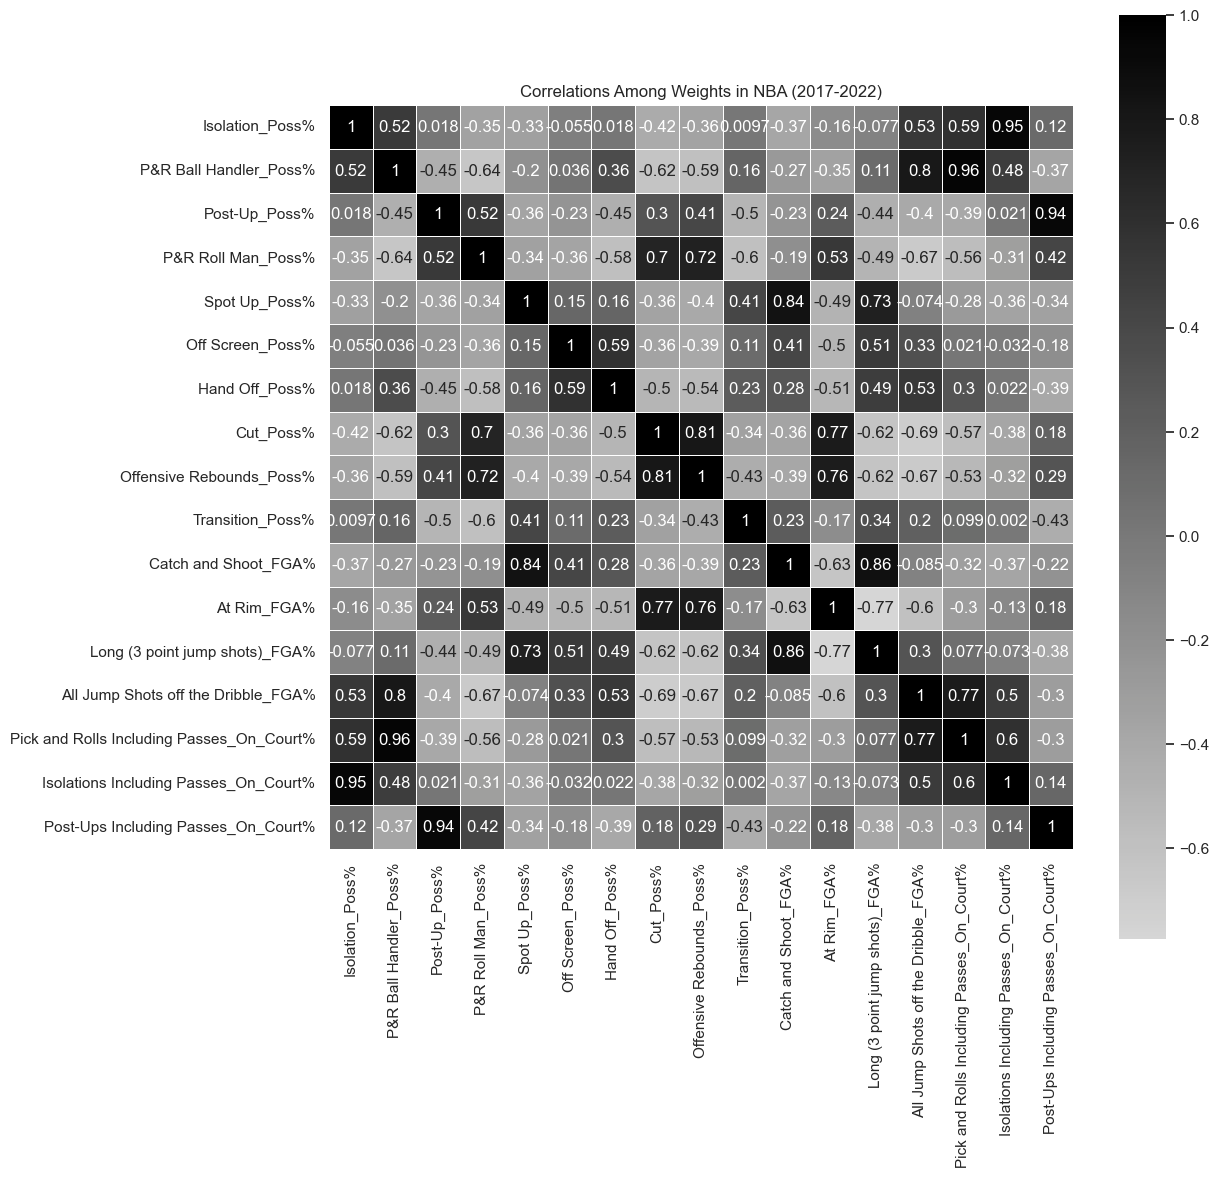

In [24]:
figsize(12, 8)
corr = df[weights].corr()
f, ax = plt.subplots(figsize=(12, 12))
cmap = sns.light_palette('black', as_cmap=True)
sns.heatmap(corr, 
            cmap=cmap, vmax=None, center=0,
            square=True, annot=True, linewidths=.5)
plt.title('Correlations Among Weights in NBA (2017-2022)')

### Reduce Dimensions with PCA

In [25]:
X = df[weights].copy()

Determine how many components reduce down to via PCA

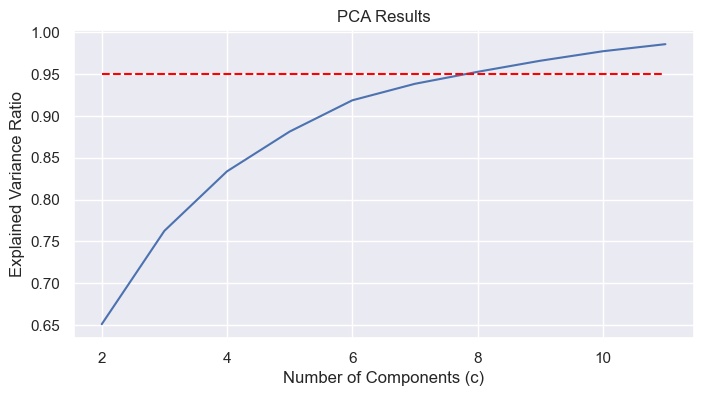

In [26]:
figsize(8, 4)
pre_pca_pipe = make_pipeline(RobustScaler(), StandardScaler())
plot_pca_explained_var(pre_pca_pipe.fit_transform(X))

Choosse 8

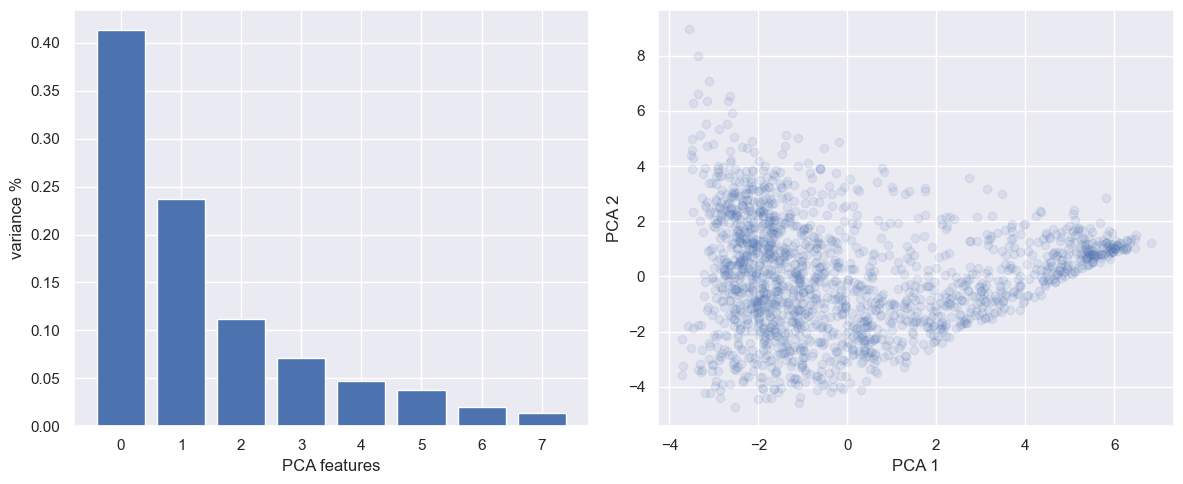

In [27]:
n_components = 8

pre_pca_pipe = make_pipeline(RobustScaler(), StandardScaler())
pca = PCA(n_components=n_components)
pca.fit(pre_pca_pipe.fit_transform(X))
pca_components = pca.transform(pre_pca_pipe.fit_transform(X))

figsize(12, 5)
plt.subplot(1, 2, 1)
plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(range(pca.n_components_))

plt.subplot(1, 2, 2)
plt.scatter(pca_components[:, 0], pca_components[:, 1], alpha=.1)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.tight_layout()

In [28]:
pre_cluster_scaler = StandardScaler()
X_transformed = pre_cluster_scaler.fit_transform(pca_components)

### Choose Optimal K

Determine # of clusters using silhouette score method

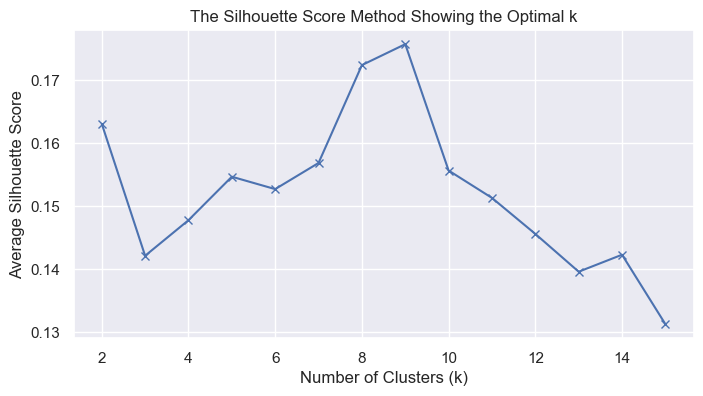

In [29]:
figsize(8, 4)
plot_silhouette_score(X_transformed)

### Clustering

In [30]:
# Choose k = 9
n_clusters = 9

sc = SpectralClustering(n_clusters=n_clusters, 
                        affinity='nearest_neighbors', 
                        random_state=42)
sc.fit(X_transformed)
df['player_cluster'] = sc.labels_
df['silhouette_coefficient'] = silhouette_samples(X_transformed, 
                                                  df['player_cluster'])
df.groupby('player_cluster').count()['Player']

player_cluster
0    382
1    117
2    206
3    129
4     50
5     40
6    147
7    522
8    121
Name: Player, dtype: int64

## Results

### Functions

In [32]:
def show_cluster_res(df, cluster_col, weights=weights):
    cluster_res = df.groupby(cluster_col)[['usg_pct', 'obpm'] + weights]\
                    .mean().sort_values('obpm', ascending=False)
    cluster_cnt = Counter(df[cluster_col])
    cluster_res['obpm'] = cluster_res['obpm'].apply(lambda x: f'{x:.2f}')
    cluster_res['usg_pct'] = cluster_res['usg_pct'].apply(lambda x: f'{x:.1f}%')
    for col in cluster_res.columns:
        if '%' in col:
            cluster_res[col] = cluster_res[col].apply(lambda x: f'{x:.2%}')
    cluster_res = cluster_res.reset_index()
    cluster_res['#'] = cluster_res[cluster_col].map(cluster_cnt)
    return cluster_res.T

### Overview

In [33]:
show_cluster_res(df, 'player_cluster')

,0,1,2,3,4,5,6,7,8
player_cluster,6,8,4,1,0,3,5,2,7
usg_pct,27.1%,24.2%,15.5%,20.5%,21.7%,16.8%,17.8%,17.0%,17.8%
obpm,2.64,1.77,0.32,0.29,-0.17,-0.24,-0.48,-0.52,-1.18
Isolation_Poss%,17.86%,5.29%,0.80%,3.75%,7.82%,1.39%,0.92%,1.72%,4.09%
P&R Ball Handler_Poss%,26.45%,1.55%,0.00%,15.05%,39.88%,0.13%,11.35%,1.46%,13.42%
Post-Up_Poss%,6.01%,25.64%,8.86%,1.29%,0.45%,7.02%,0.02%,7.29%,2.42%
P&R Roll Man_Poss%,2.05%,18.06%,21.60%,1.13%,0.13%,27.94%,0.88%,17.38%,2.48%
Spot Up_Poss%,16.21%,13.48%,3.15%,27.61%,22.08%,8.86%,28.14%,37.62%,33.18%
Off Screen_Poss%,4.68%,2.00%,0.00%,18.26%,3.22%,0.09%,13.93%,2.13%,4.05%
Hand Off_Poss%,5.22%,0.58%,0.00%,9.08%,6.54%,0.08%,23.04%,1.41%,5.91%


- Ballhandler: 6 & 0
- Big: 8 & 4 & 3 & 2
- Wing: 1 & 5 & 7

In [34]:
cluster_dict = {6: 'Ballhandler', 0: 'Ballhandler',
                8: 'Big', 4: 'Big', 3: 'Big', 2: 'Big',
                1: 'Wing', 5: 'Wing', 7: 'Wing'}

In [35]:
def color_cluster(val, cluster_dict=cluster_dict):
    if cluster_dict[val] == 'Ballhandler':
        return '#AB3B3A'
    elif cluster_dict[val] == 'Wing':
        return '#2E5C6E'
    elif cluster_dict[val] == 'Big':
        return '#F7D94C'

In [36]:
def color_cluster_pandas(val, cluster_dict=cluster_dict):
    if val in cluster_dict.keys():
        color = color_cluster(val, cluster_dict=cluster_dict)
    else:
        color = 'white'
    return f'background-color: {color}' 

In [37]:
show_cluster_res(df, 'player_cluster')\
.style.applymap(color_cluster_pandas)

,0,1,2,3,4,5,6,7,8
player_cluster,6,8,4,1,0,3,5,2,7
usg_pct,27.1%,24.2%,15.5%,20.5%,21.7%,16.8%,17.8%,17.0%,17.8%
obpm,2.64,1.77,0.32,0.29,-0.17,-0.24,-0.48,-0.52,-1.18
Isolation_Poss%,17.86%,5.29%,0.80%,3.75%,7.82%,1.39%,0.92%,1.72%,4.09%
P&R Ball Handler_Poss%,26.45%,1.55%,0.00%,15.05%,39.88%,0.13%,11.35%,1.46%,13.42%
Post-Up_Poss%,6.01%,25.64%,8.86%,1.29%,0.45%,7.02%,0.02%,7.29%,2.42%
P&R Roll Man_Poss%,2.05%,18.06%,21.60%,1.13%,0.13%,27.94%,0.88%,17.38%,2.48%
Spot Up_Poss%,16.21%,13.48%,3.15%,27.61%,22.08%,8.86%,28.14%,37.62%,33.18%
Off Screen_Poss%,4.68%,2.00%,0.00%,18.26%,3.22%,0.09%,13.93%,2.13%,4.05%
Hand Off_Poss%,5.22%,0.58%,0.00%,9.08%,6.54%,0.08%,23.04%,1.41%,5.91%


### Top & Bottom Players by Cluster

In [38]:
def display_cluster_players(df, cluster_col, cluster_label):
    cols = ['Player', 'Season', 'Team', 'obpm']
    best_10 = df[df[cluster_col] == cluster_label].sort_values('obpm', ascending=False)\
                                                  .head(10)[cols]\
                                                  .rename(columns={'Player': 'Best 10 Players'})\
                                                  .reset_index().drop('index', axis=1)
    worst_10 = df[df[cluster_col] == cluster_label].sort_values('obpm')\
                                                   .head(10)[cols]\
                                                   .rename(columns={'Player': 'Worst 10 Players'})\
                                                   .reset_index().drop('index', axis=1)
    return pd.concat([best_10, worst_10], axis=1)

Ballhandlers

In [39]:
c = 6
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 147


,Best 10 Players,Season,Team,obpm,Worst 10 Players,Season,Team,obpm
0,James Harden,2018-2019,Houston Rockets,9.4,Austin Rivers,2018-2019,Washington Wizards,-4.1
1,James Harden,2017-2018,Houston Rockets,8.5,Austin Rivers,2021-2022,Denver Nuggets,-3.5
2,Damian Lillard,2019-2020,Portland Trail Blazers,8.3,Kevin Porter Jr.,2019-2020,Cleveland Cavaliers,-3.2
3,James Harden,2019-2020,Houston Rockets,8.1,Austin Rivers,2018-2019,Houston Rockets,-2.9
4,Giannis Antetokounmpo,2021-2022,Milwaukee Bucks,7.6,James Johnson,2018-2019,Miami Heat,-2.4
5,Damian Lillard,2020-2021,Portland Trail Blazers,7.5,Austin Rivers,2019-2020,Houston Rockets,-2.1
6,Giannis Antetokounmpo,2019-2020,Milwaukee Bucks,7.4,Dion Waiters,2017-2018,Miami Heat,-2.1
7,Luka Doncic,2019-2020,Dallas Mavericks,7.4,Brandon Ingram,2018-2019,Los Angeles Lakers,-1.3
8,LeBron James,2017-2018,Cleveland Cavaliers,7.3,Dennis Smith Jr.,2017-2018,Dallas Mavericks,-1.2
9,Damian Lillard,2017-2018,Portland Trail Blazers,7.0,Dennis Schroder,2021-2022,Boston Celtics,-1.2


In [40]:
c = 0
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 382


,Best 10 Players,Season,Team,obpm,Worst 10 Players,Season,Team,obpm
0,Trae Young,2021-2022,Atlanta Hawks,7.1,Killian Hayes,2020-2021,Detroit Pistons,-6.3
1,Kyrie Irving,2019-2020,Brooklyn Nets,6.7,Dennis Smith Jr.,2019-2020,New York Knicks,-5.2
2,Trae Young,2019-2020,Atlanta Hawks,6.2,Frank Ntilikina,2018-2019,New York Knicks,-5.2
3,Ja Morant,2021-2022,Memphis Grizzlies,6.2,Aleksej Pokusevski,2020-2021,Oklahoma City Thunder,-5.1
4,Jimmy Butler,2020-2021,Miami Heat,5.4,Chasson Randle,2020-2021,Orlando Magic,-4.8
5,Trae Young,2020-2021,Atlanta Hawks,5.3,Dwayne Bacon,2017-2018,Charlotte Hornets,-4.8
6,Kemba Walker,2018-2019,Charlotte Hornets,5.2,Elfrid Payton,2021-2022,Phoenix Suns,-4.6
7,Tyreke Evans,2017-2018,Memphis Grizzlies,4.9,Jonathon Simmons,2018-2019,Orlando Magic,-4.6
8,Zach Lavine,2020-2021,Chicago Bulls,4.9,Michael Carter-Williams,2020-2021,Orlando Magic,-4.6
9,Kemba Walker,2019-2020,Boston Celtics,4.9,Frank Ntilikina,2017-2018,New York Knicks,-4.5


Bigs

In [41]:
c = 8
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 121


,Best 10 Players,Season,Team,obpm,Worst 10 Players,Season,Team,obpm
0,Nikola Jokic,2021-2022,Denver Nuggets,9.2,James Wiseman,2020-2021,Golden State Warriors,-4.0
1,Nikola Jokic,2020-2021,Denver Nuggets,9.1,Harry Giles,2018-2019,Sacramento Kings,-3.4
2,Joel Embiid,2021-2022,Philadelphia 76ers,7.2,DeMarcus Cousins,2021-2022,Denver Nuggets,-2.8
3,Anthony Davis,2018-2019,New Orleans Pelicans,7.1,Dirk Nowitzki,2018-2019,Dallas Mavericks,-2.7
4,Karl-Anthony Towns,2019-2020,Minnesota Timberwolves,7.0,Andre Drummond,2020-2021,Los Angeles Lakers,-2.7
5,Joel Embiid,2020-2021,Philadelphia 76ers,6.3,Robin Lopez,2021-2022,Orlando Magic,-2.4
6,Nikola Jokic,2018-2019,Denver Nuggets,6.2,Joe Johnson,2017-2018,Utah Jazz,-2.3
7,Zion Williamson,2020-2021,New Orleans Pelicans,6.1,JaVale McGee,2020-2021,Cleveland Cavaliers,-2.3
8,Nikola Vucevic,2020-2021,Orlando Magic,5.5,Skal Labissiere,2017-2018,Sacramento Kings,-1.9
9,Nikola Jokic,2019-2020,Denver Nuggets,5.5,Blake Griffin,2020-2021,Detroit Pistons,-1.9


In [42]:
c = 4
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 50


,Best 10 Players,Season,Team,obpm,Worst 10 Players,Season,Team,obpm
0,Rudy Gobert,2018-2019,Utah Jazz,3.0,Ian Mahinmi,2017-2018,Washington Wizards,-4.6
1,Rudy Gobert,2021-2022,Utah Jazz,2.9,Zaza Pachulia,2018-2019,Detroit Pistons,-2.8
2,Robert Williams III,2020-2021,Boston Celtics,2.9,Isaiah Stewart,2021-2022,Detroit Pistons,-2.5
3,Clint Capela,2020-2021,Atlanta Hawks,2.7,Dwight Howard,2020-2021,Philadelphia 76ers,-2.1
4,Robert Williams III,2021-2022,Boston Celtics,2.4,Kevon Looney,2020-2021,Golden State Warriors,-1.8
5,Clint Capela,2021-2022,Atlanta Hawks,2.2,Tristan Thompson,2020-2021,Boston Celtics,-1.5
6,Enes Kanter,2020-2021,Portland Trail Blazers,2.1,Moses Brown,2020-2021,Oklahoma City Thunder,-1.3
7,Ivica Zubac,2019-2020,Los Angeles Clippers,1.9,Ed Davis,2017-2018,Portland Trail Blazers,-1.2
8,Willy Hernangomez,2021-2022,New Orleans Pelicans,1.8,Andre Drummond,2021-2022,Philadelphia 76ers,-1.2
9,Rudy Gobert,2019-2020,Utah Jazz,1.7,Amir Johnson,2017-2018,Philadelphia 76ers,-1.2


In [43]:
c = 3
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 129


,Best 10 Players,Season,Team,obpm,Worst 10 Players,Season,Team,obpm
0,John Collins,2019-2020,Atlanta Hawks,3.7,Miles Plumlee,2017-2018,Atlanta Hawks,-3.7
1,Clint Capela,2018-2019,Houston Rockets,3.3,Precious Achiuwa,2020-2021,Miami Heat,-3.6
2,Brandon Clarke,2021-2022,Memphis Grizzlies,3.1,Aron Baynes,2017-2018,Boston Celtics,-3.6
3,Bam Adebayo,2020-2021,Miami Heat,2.9,Bismack Biyombo,2020-2021,Charlotte Hornets,-3.4
4,Thomas Bryant,2019-2020,Washington Wizards,2.9,Alex Len,2021-2022,Sacramento Kings,-3.2
5,Jarrett Allen,2021-2022,Cleveland Cavaliers,2.7,Bruno Fernando,2019-2020,Atlanta Hawks,-3.2
6,Hassan Whiteside,2019-2020,Portland Trail Blazers,2.5,Cristiano Felicio,2017-2018,Chicago Bulls,-2.8
7,Jonas Valanciunas,2017-2018,Toronto Raptors,2.4,Ian Mahinmi,2019-2020,Washington Wizards,-2.8
8,Brandon Clarke,2019-2020,Memphis Grizzlies,2.4,Bismack Biyombo,2017-2018,Orlando Magic,-2.6
9,Clint Capela,2017-2018,Houston Rockets,2.4,Nerlens Noel,2020-2021,New York Knicks,-2.4


In [44]:
c = 2
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 206


,Best 10 Players,Season,Team,obpm,Worst 10 Players,Season,Team,obpm
0,Nikola Mirotic,2017-2018,Chicago Bulls,4.9,Terrance Ferguson,2019-2020,Oklahoma City Thunder,-4.8
1,Kevin Love,2021-2022,Cleveland Cavaliers,4.3,Zach Collins,2017-2018,Portland Trail Blazers,-4.5
2,Danilo Gallinari,2019-2020,Oklahoma City Thunder,4.1,Grant Williams,2019-2020,Boston Celtics,-4.1
3,Mike Muscala,2021-2022,Oklahoma City Thunder,3.8,Grant Williams,2020-2021,Boston Celtics,-4.0
4,Al Horford,2018-2019,Boston Celtics,3.3,Aron Baynes,2020-2021,Toronto Raptors,-3.4
5,Jalen Smith,2021-2022,Indiana Pacers,2.9,Dragan Bender,2018-2019,Phoenix Suns,-3.4
6,Chris Boucher,2020-2021,Toronto Raptors,2.7,Jaden McDaniels,2020-2021,Minnesota Timberwolves,-3.3
7,John Collins,2020-2021,Atlanta Hawks,2.5,Lance Thomas,2017-2018,New York Knicks,-3.2
8,Bobby Portis,2017-2018,Chicago Bulls,2.2,Marquese Chriss,2017-2018,Phoenix Suns,-3.2
9,Trey Lyles,2017-2018,Denver Nuggets,2.0,Thon Maker,2017-2018,Milwaukee Bucks,-3.2


Wings

In [45]:
c = 1
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 117


,Best 10 Players,Season,Team,obpm,Worst 10 Players,Season,Team,obpm
0,Stephen Curry,2020-2021,Golden State Warriors,8.3,Jordan Poole,2019-2020,Golden State Warriors,-4.4
1,Stephen Curry,2017-2018,Golden State Warriors,7.8,Gary Harris,2020-2021,Orlando Magic,-3.6
2,Stephen Curry,2018-2019,Golden State Warriors,7.1,Ben McLemore,2020-2021,Houston Rockets,-3.4
3,Stephen Curry,2021-2022,Golden State Warriors,5.4,Ian Clark,2018-2019,New Orleans Pelicans,-3.3
4,Bradley Beal,2019-2020,Washington Wizards,5.3,Justin Holiday,2018-2019,Memphis Grizzlies,-3.3
5,Bradley Beal,2020-2021,Washington Wizards,4.8,CJ Miles,2018-2019,Toronto Raptors,-3.2
6,Bradley Beal,2018-2019,Washington Wizards,3.8,Ben McLemore,2017-2018,Memphis Grizzlies,-2.9
7,Paul George,2019-2020,Los Angeles Clippers,3.8,Damion Lee,2021-2022,Golden State Warriors,-2.4
8,Buddy Hield,2018-2019,Sacramento Kings,3.5,Allen Crabbe,2018-2019,Brooklyn Nets,-2.4
9,Bogdan Bogdanovic,2020-2021,Atlanta Hawks,3.3,Darius Miller,2018-2019,New Orleans Pelicans,-2.1


In [46]:
c = 5
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 40


,Best 10 Players,Season,Team,obpm,Worst 10 Players,Season,Team,obpm
0,JJ Redick,2017-2018,Philadelphia 76ers,2.2,Gary Harris,2019-2020,Denver Nuggets,-2.8
1,JJ Redick,2018-2019,Philadelphia 76ers,2.2,Avery Bradley,2017-2018,Detroit Pistons,-2.8
2,Duncan Robinson,2019-2020,Miami Heat,1.5,Justin Holiday,2021-2022,Sacramento Kings,-2.6
3,Doug McDermott,2020-2021,Indiana Pacers,1.4,Terrence Ross,2021-2022,Orlando Magic,-2.5
4,Doug McDermott,2019-2020,Indiana Pacers,1.4,Rodney McGruder,2018-2019,Miami Heat,-2.2
5,Wayne Ellington,2020-2021,Detroit Pistons,1.1,Gary Harris,2021-2022,Orlando Magic,-2.0
6,Wayne Ellington,2017-2018,Miami Heat,1.0,Troy Daniels,2018-2019,Phoenix Suns,-1.7
7,Gary Harris,2017-2018,Denver Nuggets,1.0,Justin Holiday,2017-2018,Chicago Bulls,-1.6
8,Reggie Bullock,2017-2018,Detroit Pistons,0.7,Garrison Mathews,2021-2022,Houston Rockets,-1.3
9,Wayne Ellington,2018-2019,Detroit Pistons,0.0,Gary Harris,2018-2019,Denver Nuggets,-1.2


In [47]:
c = 7
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 522


,Best 10 Players,Season,Team,obpm,Worst 10 Players,Season,Team,obpm
0,Kyle Lowry,2017-2018,Toronto Raptors,4.7,Justise Winslow,2020-2021,Memphis Grizzlies,-6.2
1,Michael Porter Jr.,2020-2021,Denver Nuggets,4.0,Dwayne Bacon,2019-2020,Charlotte Hornets,-5.9
2,Christian Wood,2019-2020,Detroit Pistons,3.5,Tyrone Wallace,2018-2019,Los Angeles Clippers,-5.6
3,Jaylen Brown,2020-2021,Boston Celtics,3.2,Paul Zipser,2017-2018,Chicago Bulls,-5.5
4,Kelly Olynyk,2020-2021,Houston Rockets,2.9,Sekou Doumbouya,2020-2021,Detroit Pistons,-5.4
5,Tobias Harris,2020-2021,Philadelphia 76ers,2.9,Jawun Evans,2017-2018,Los Angeles Clippers,-5.4
6,Josh Hart,2021-2022,Portland Trail Blazers,2.8,Jalen Suggs,2021-2022,Orlando Magic,-5.3
7,John Collins,2018-2019,Atlanta Hawks,2.8,Rodney Hood,2020-2021,Portland Trail Blazers,-5.3
8,Jamal Murray,2020-2021,Denver Nuggets,2.7,Sekou Doumbouya,2019-2020,Detroit Pistons,-5.2
9,Desmond Bane,2021-2022,Memphis Grizzlies,2.5,Kobi Simmons,2017-2018,Memphis Grizzlies,-4.7


### Edge Cases

In [48]:
temp = df.groupby('Player')['player_cluster'].apply(list).reset_index()
temp['player_cluster_adj'] = temp['player_cluster'].apply(lambda x: [cluster_dict[s] 
                                                                     for s in x])\
                                                   .apply(set)
temp['player_cluster'] = temp['player_cluster'].apply(set)
temp['n_cluster'] = temp['player_cluster_adj'].apply(len)
temp[temp['n_cluster'] == 3]

,Player,player_cluster,player_cluster_adj,n_cluster
52,Bruce Brown,"{0, 3, 7}","{Ballhandler, Wing, Big}",3
170,Eric Paschall,"{2, 6, 7}","{Ballhandler, Wing, Big}",3
262,Jerami Grant,"{2, 6, 7}","{Ballhandler, Wing, Big}",3
438,Otto Porter Jr.,"{0, 1, 2, 7}","{Ballhandler, Wing, Big}",3
475,Rudy Gay,"{2, 6, 7}","{Ballhandler, Wing, Big}",3


In [49]:
temp[(temp['n_cluster'] == 2) & 
     (temp['player_cluster_adj'] == set(['Ballhandler', 'Big']))]


,Player,player_cluster,player_cluster_adj,n_cluster
68,Carmelo Anthony,"{8, 6}","{Ballhandler, Big}",2
101,Danilo Gallinari,"{2, 6}","{Ballhandler, Big}",2
121,DeMarcus Cousins,"{8, 2, 6}","{Ballhandler, Big}",2
306,Julius Randle,"{8, 6}","{Ballhandler, Big}",2
312,Karl-Anthony Towns,"{8, 6}","{Ballhandler, Big}",2
376,Marcus Morris,"{2, 6}","{Ballhandler, Big}",2
444,Patrick Beverley,"{0, 2}","{Ballhandler, Big}",2


## Visualization via TSNE

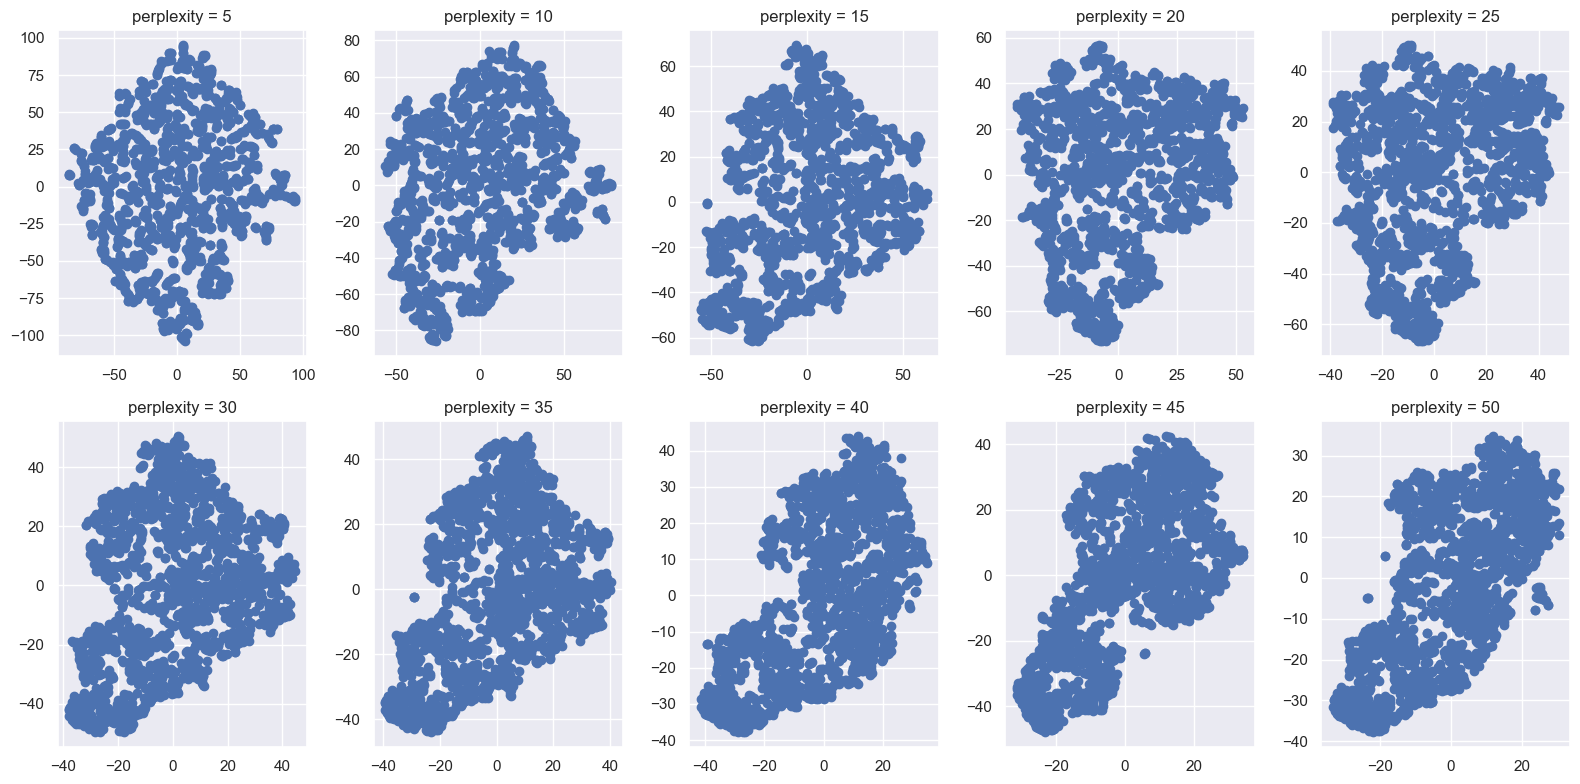

In [50]:
figsize(16, 8)
for i in list(range(1, 11)):
    plt.subplot(2, 5, i)
    perplexity = 5 * i
    tsne = TSNE(perplexity=perplexity, random_state=0)
    X_tsne = tsne.fit_transform(X_transformed)
    plt.scatter(X_tsne[:,0], X_tsne[:, 1])
    plt.title(f'perplexity = {perplexity}')
plt.tight_layout()

In [51]:
tsne = TSNE(perplexity=20, random_state=0)
X_tsne = tsne.fit_transform(X_transformed)

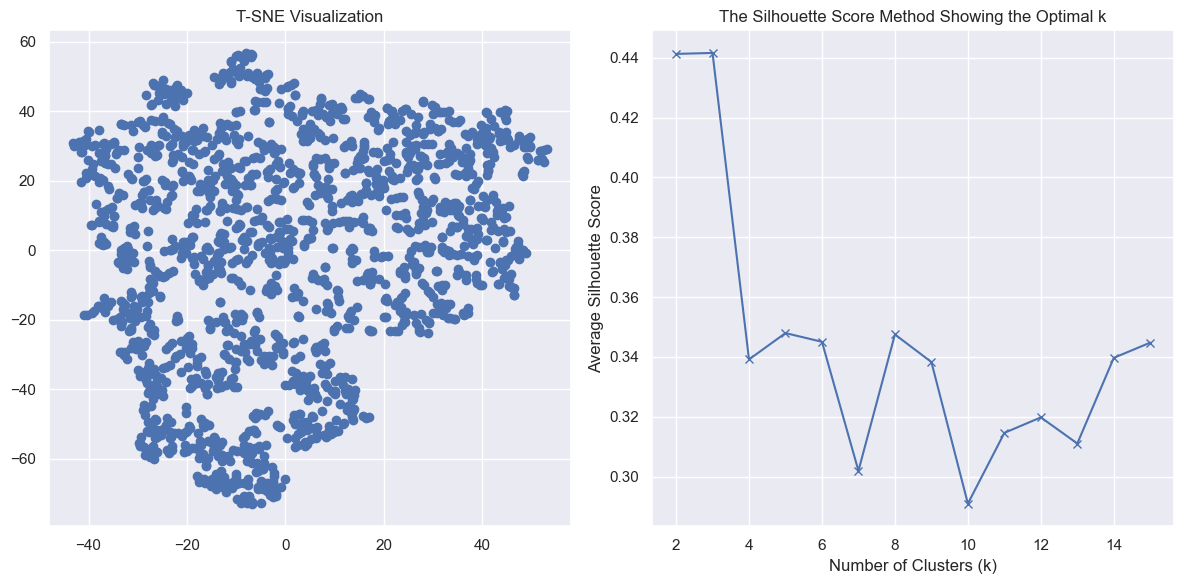

In [52]:
figsize(12, 6)
plt.subplot(1, 2, 1)
plt.scatter(X_tsne[:,0], X_tsne[:, 1])
plt.title('T-SNE Visualization')
plt.subplot(1, 2, 2)
plot_silhouette_score(X_tsne)
plt.tight_layout()

In [53]:
df_tsne = df.copy()
# Choose k = 8
sc_tsne = SpectralClustering(n_clusters=8, 
                             affinity='nearest_neighbors', 
                             random_state=42)
sc_tsne.fit(X_tsne)
df_tsne['cluster_label_tsne'] = sc_tsne.labels_

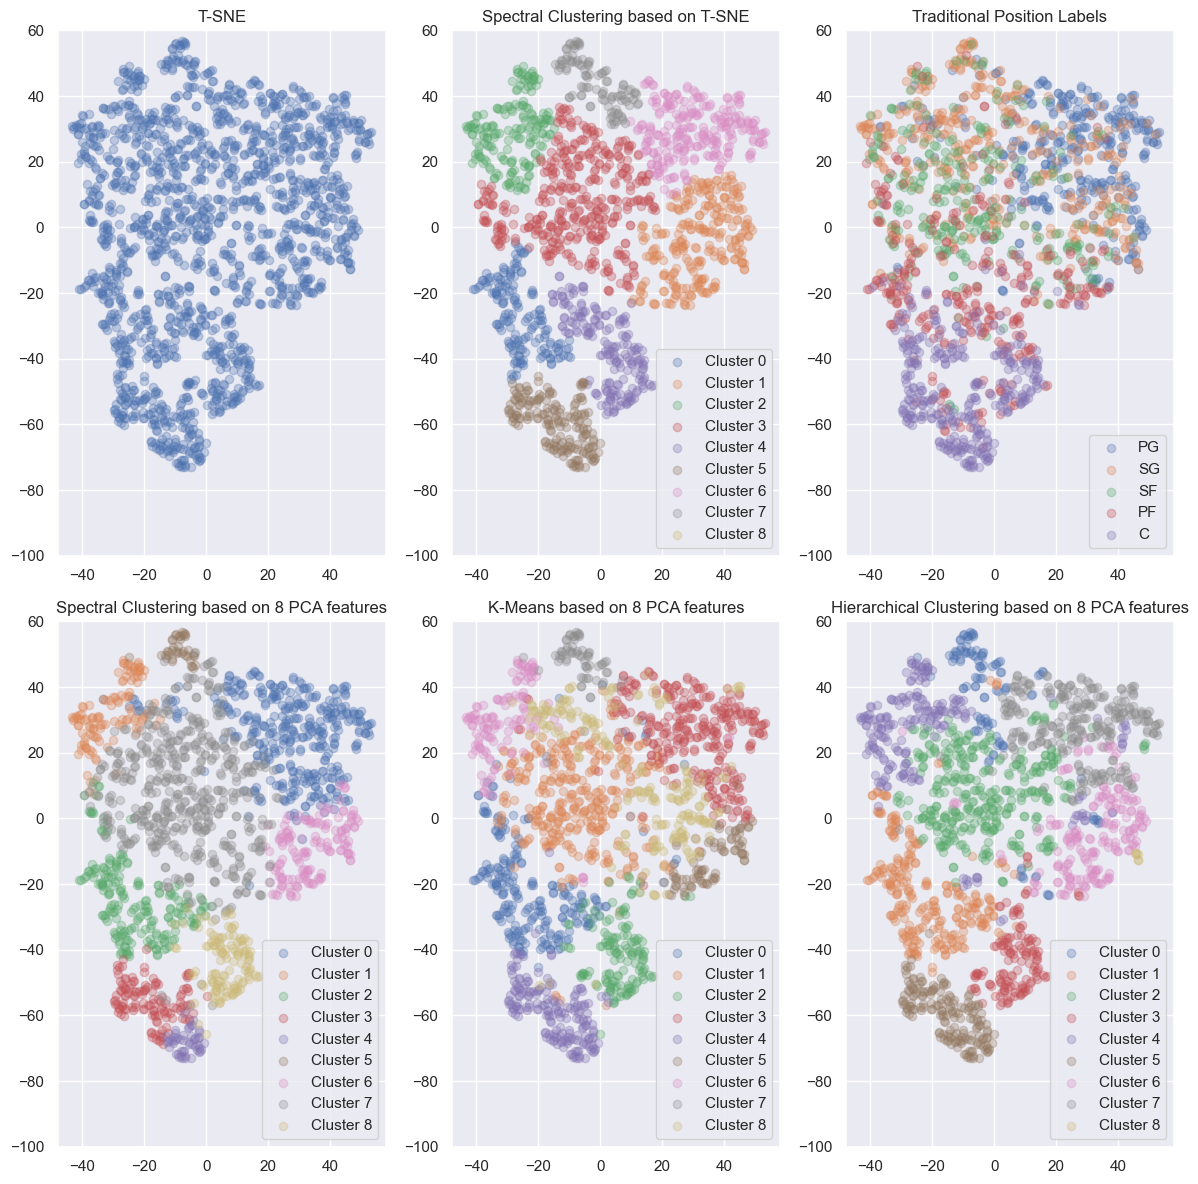

In [54]:
figsize(12, 12)

plt.subplot(2, 3, 1)
plt.scatter(X_tsne[:,0], X_tsne[:, 1], alpha=0.3)
plt.title('T-SNE')
plt.ylim(-100, 60)

plt.subplot(2, 3, 2)
for i in range(9):
    cluster_cond = df_tsne['cluster_label_tsne'] == i
    cluster_index = df_tsne[cluster_cond].index
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
plt.legend(loc='lower right')
plt.ylim(-100, 60)
plt.title('Spectral Clustering based on T-SNE')

plt.subplot(2, 3, 3)
for idx, pos in enumerate(['PG', 'SG', 'SF', 'PF', 'C'], 1):
    pos_cond = df['pos'] == pos
    pos_index = df[pos_cond].index
    plt.scatter(X_tsne[pos_index, 0], X_tsne[pos_index, 1], label=pos, alpha=0.3)
plt.legend(loc='lower right')
plt.ylim(-100, 60)
plt.title('Traditional Position Labels')

plt.subplot(2, 3, 4)
sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
plt.legend(loc='lower right')
plt.ylim(-100, 60)
plt.title(f'Spectral Clustering based on {n_components} PCA features')

plt.subplot(2, 3, 5)
km = KMeans(n_clusters=n_clusters, random_state=42)
labels = km.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
plt.legend(loc='lower right')
plt.ylim(-100, 60)
plt.title(f'K-Means based on {n_components} PCA features')

plt.subplot(2, 3, 6)
agc = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean',
                              linkage='ward')
labels = agc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
plt.legend(loc='lower right')
plt.ylim(-100, 60)
plt.title(f'Hierarchical Clustering based on {n_components} PCA features')

plt.tight_layout()